# Описание
Работаю с данными. Генерирую признаки.
- Трансформация цены в относительные приросты
- добавление признаков из даты
- добавление ТА
- Работаю с целевым признаком. Прирост на следуюем баре оформляю в виде класса с каким-то уровнем роста.

- Логарифмирование цен и логарифмирование и прироста
- 

# Import modules

In [130]:
# for use R2Score metrics
# !pip install tf-nightly

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки

import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

# Load Data

In [3]:
df = pd.read_parquet('..\ETH-Full-1H.parquet')

In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49337 entries, 2017-09-01 00:00:00 to 2023-04-23 23:00:00
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    49337 non-null  float64
 1   High    49337 non-null  float64
 2   Low     49337 non-null  float64
 3   Close   49337 non-null  float64
 4   Volume  49337 non-null  float64
 5   Trades  49337 non-null  int32  
dtypes: float64(5), int32(1)
memory usage: 2.4 MB


In [134]:
df

,Open,High,Low,Close,Volume,Trades
Datetime,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128
...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824


# Feature Enginiring

### Признак прироста обычный, лог, в %

In [135]:
df['Return'] = df['Close'] - df['Open']
df['Return_log'] = np.log(df['Close']) - np.log(df['Open'])
df['Return_pct'] = (df['Close'] / df['Open'] - 1) * 100

In [136]:
df

,Open,High,Low,Close,Volume,Trades,Return,Return_log,Return_pct
Datetime,,,,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131,3.95,0.010213,1.026534
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262,2.68,0.006871,0.689495
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225,-2.00,-0.005104,-0.509061
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138,-0.84,-0.002147,-0.214450
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128,-2.32,-0.005926,-0.590857
...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648,-0.27,-0.000146,-0.014620
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445,2.40,0.001299,0.129976
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824,5.78,0.003121,0.312622


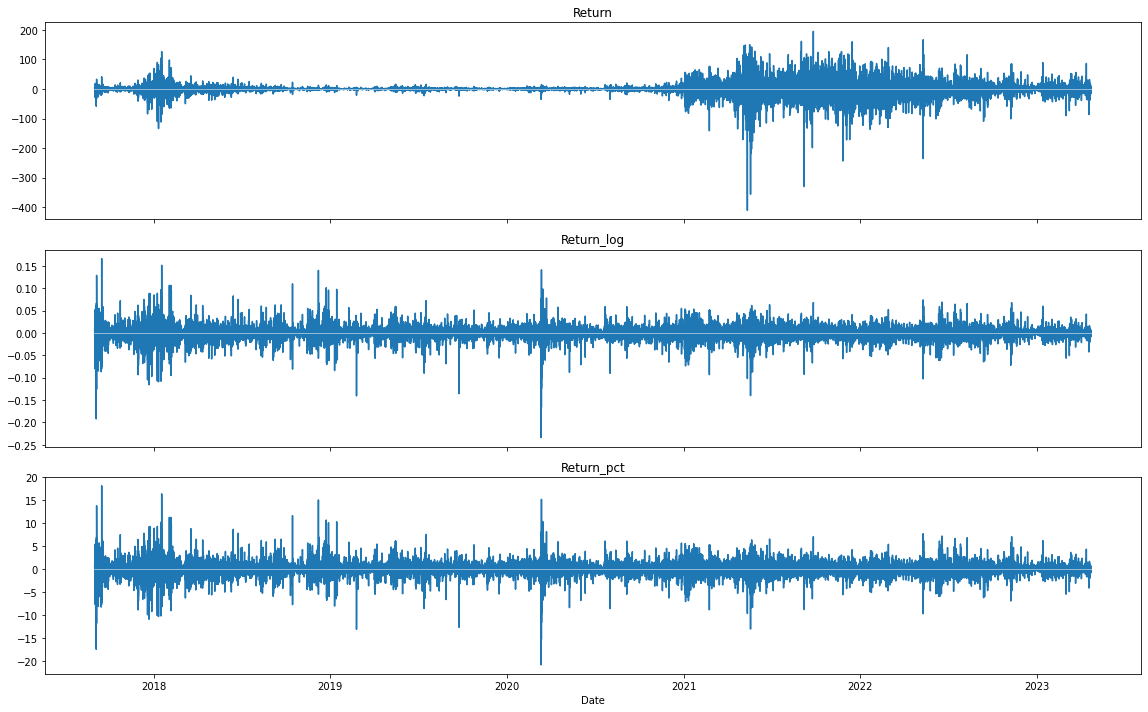

In [137]:
# Create a 3-row, 1-column subplot grid
fig, ax = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# Convert index and columns to NumPy arrays
index_array = df.index.to_numpy()
return_array = df['Return'].to_numpy()
return_log_array = df['Return_log'].to_numpy()
return_pct_array = df['Return_pct'].to_numpy()

# Plot the 'Return' column
ax[0].plot(index_array, return_array)
ax[0].axhline(0, color='white', linestyle='-', linewidth=0.5)
ax[0].set_title('Return')

# Plot the 'Return_log' column
ax[1].plot(index_array, return_log_array)
ax[1].axhline(0, color='white', linestyle='-', linewidth=0.5)
ax[1].set_title('Return_log')

# Plot the 'Return_pct' column
ax[2].plot(index_array, return_pct_array)
ax[2].axhline(0, color='white', linestyle='-', linewidth=0.5)
ax[2].set_title('Return_pct')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

При логарифмировании ряд становится стационарнее. Логарифмический прирост это тоже самое что и % прироста.
Логарифмические прирост отдаю модели в качестве инпута, а вот процентный прирост удобне просто по значениям использовать для построения целевого признака.

### Изучение цен обычных и логарифмированных

In [138]:
df['Close_log'] = np.log(df['Close'])

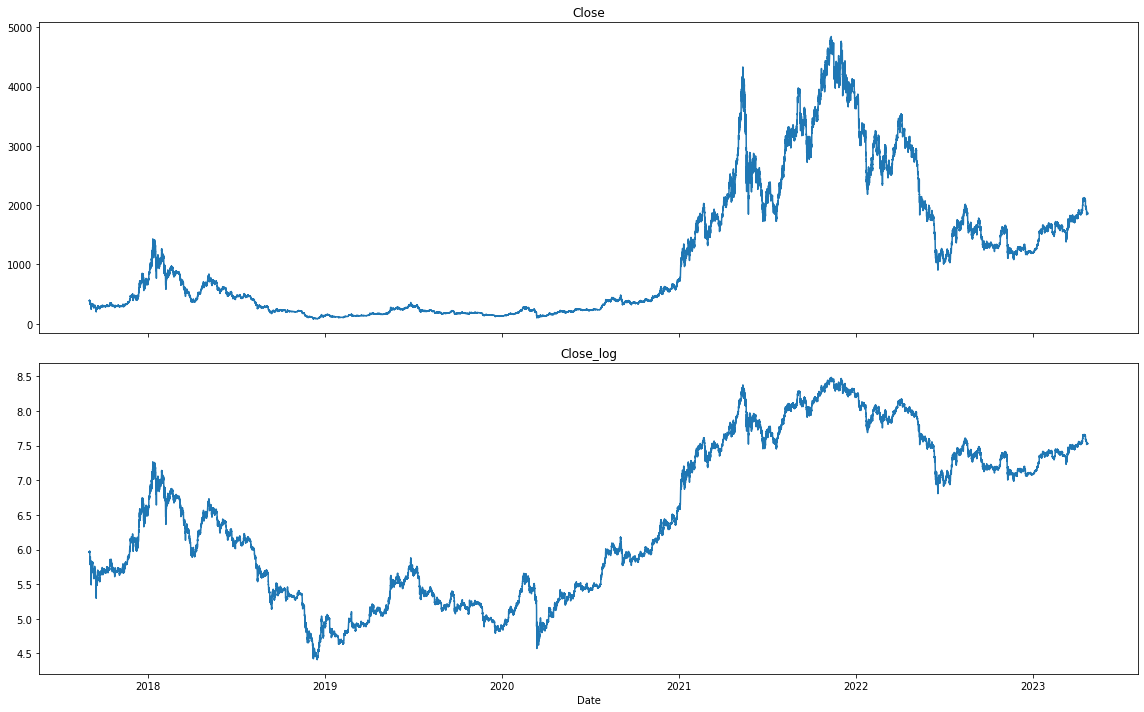

In [139]:
# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert index and columns to NumPy arrays
index_array = df.index.to_numpy()
close_array = df['Close'].to_numpy()
close_log_array = df['Close_log'].to_numpy()

ax[0].plot(index_array, close_array)
ax[0].set_title('Close')

ax[1].plot(index_array, close_log_array)
ax[1].set_title('Close_log')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

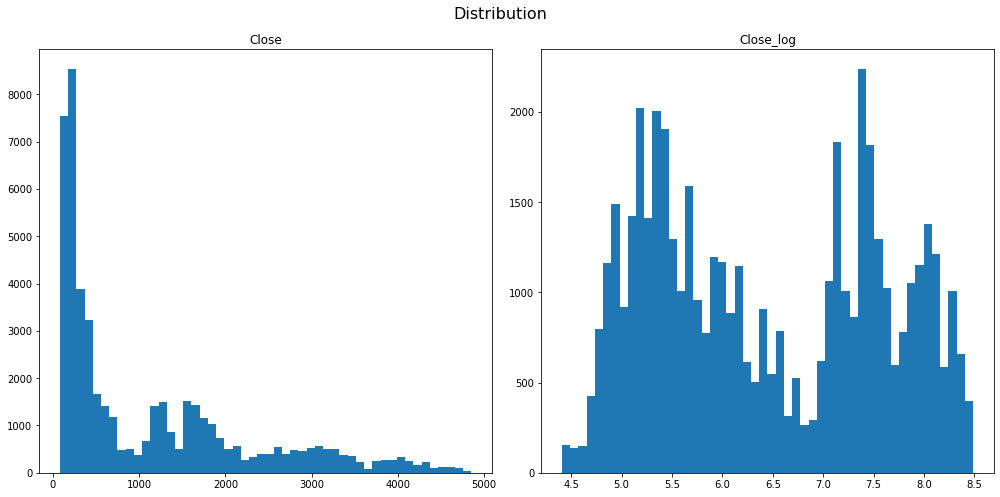

In [140]:
# Create a 1-row, 2-column subplot grid
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Distribution', fontsize=16)

ax[0].hist(df['Close'], 50)
ax[0].set_title('Close')

ax[1].hist(df['Close_log'], 50)
ax[1].set_title('Close_log')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

### Исследую оставшиеся признаки. Изучаю их распределения

In [141]:
cols_to_hist = ['Open', 'High', 'Low', 'Volume', 'Trades']

In [142]:
n_plots = len(cols_to_hist)

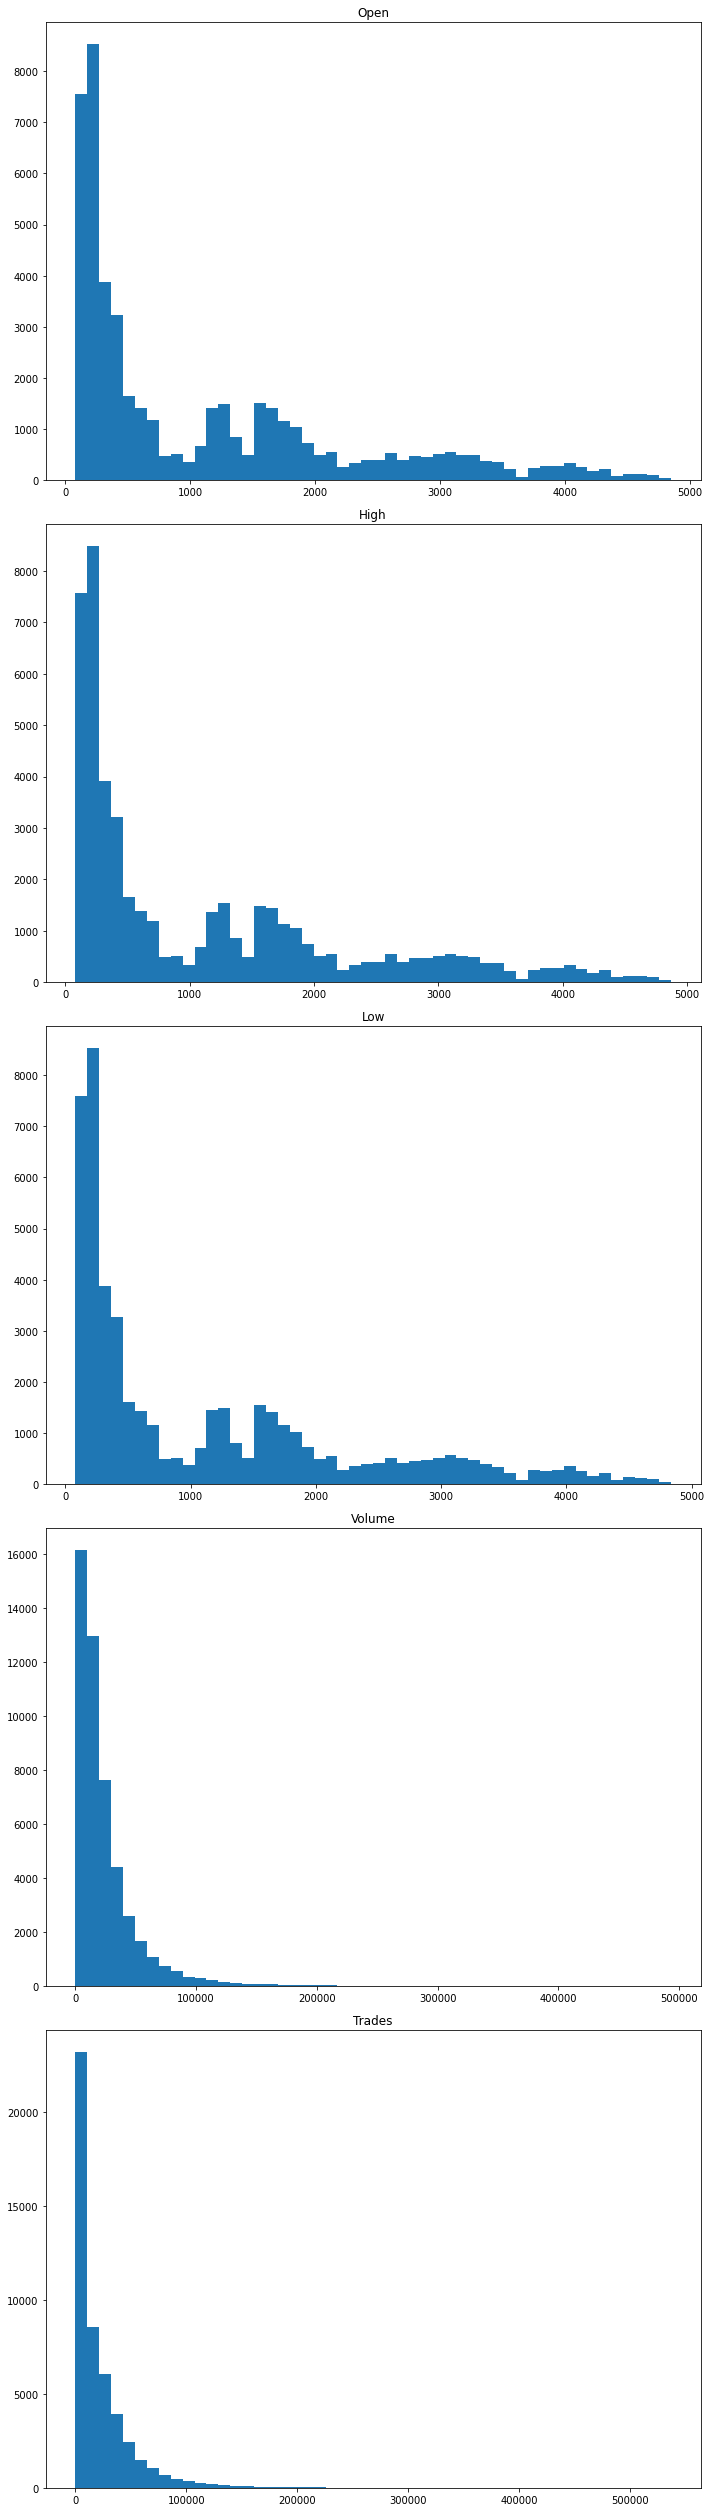

In [143]:
fig, ax = plt.subplots(n_plots, 1, figsize=(10, n_plots * 7))

i = 0
for col_name in cols_to_hist:   
    ax[i].hist(df[col_name], 50)
    ax[i].set_title(col_name)
    i += 1

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Все признаки выглядят лог-нормально. Нужно логарифмировать.
Начинаю с Volume, Trades

Проверяю нет ли нулей в этих признаках

In [144]:
df[['Volume', 'Trades']].describe()

,Volume,Trades
count,49337.000000,49337.000000
mean,24069.305450,23040.347123
std,28507.816928,29913.374971
min,1.459450,7.000000
25%,7683.970060,4858.000000
50%,15761.451700,12221.000000
75%,30009.152030,30603.000000
max,493227.882820,536376.000000


Все ок, нулей нет, можно спокойно логарифмировать

In [145]:
df['Volume_log'] = np.log(df['Volume'])
df['Trades_log'] = np.log(df['Trades'])

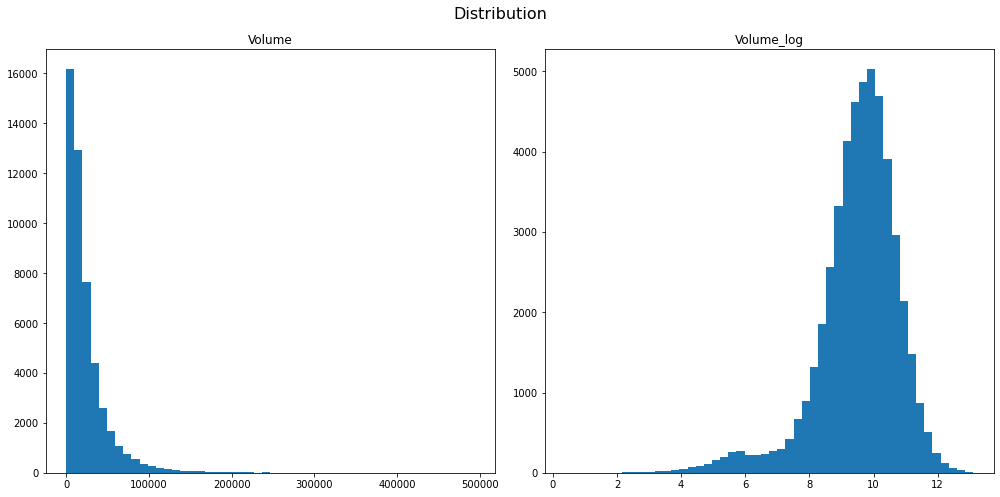

In [146]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Distribution', fontsize=16)

ax[0].hist(df['Volume'], 50)
ax[0].set_title('Volume')

ax[1].hist(df['Volume_log'], 50)
ax[1].set_title('Volume_log')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

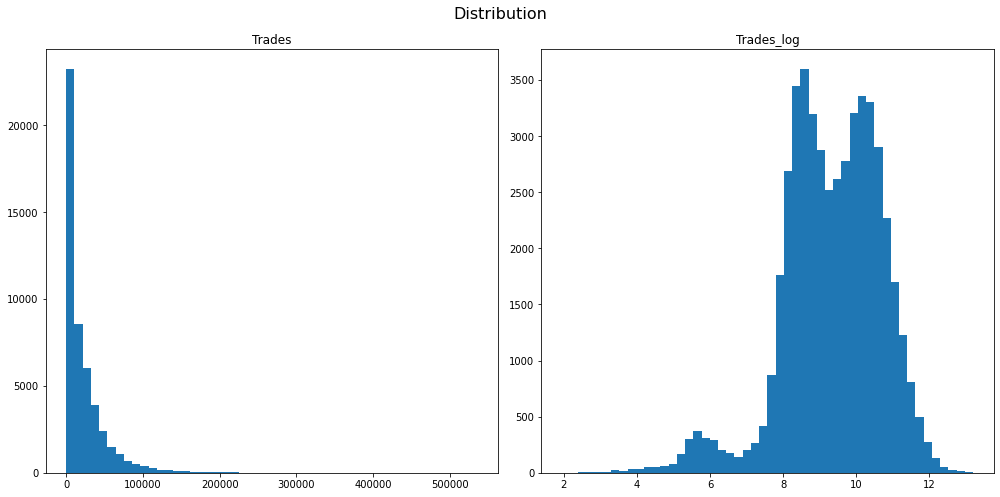

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Distribution', fontsize=16)

ax[0].hist(df['Trades'], 50)
ax[0].set_title('Trades')

ax[1].hist(df['Trades_log'], 50)
ax[1].set_title('Trades_log')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

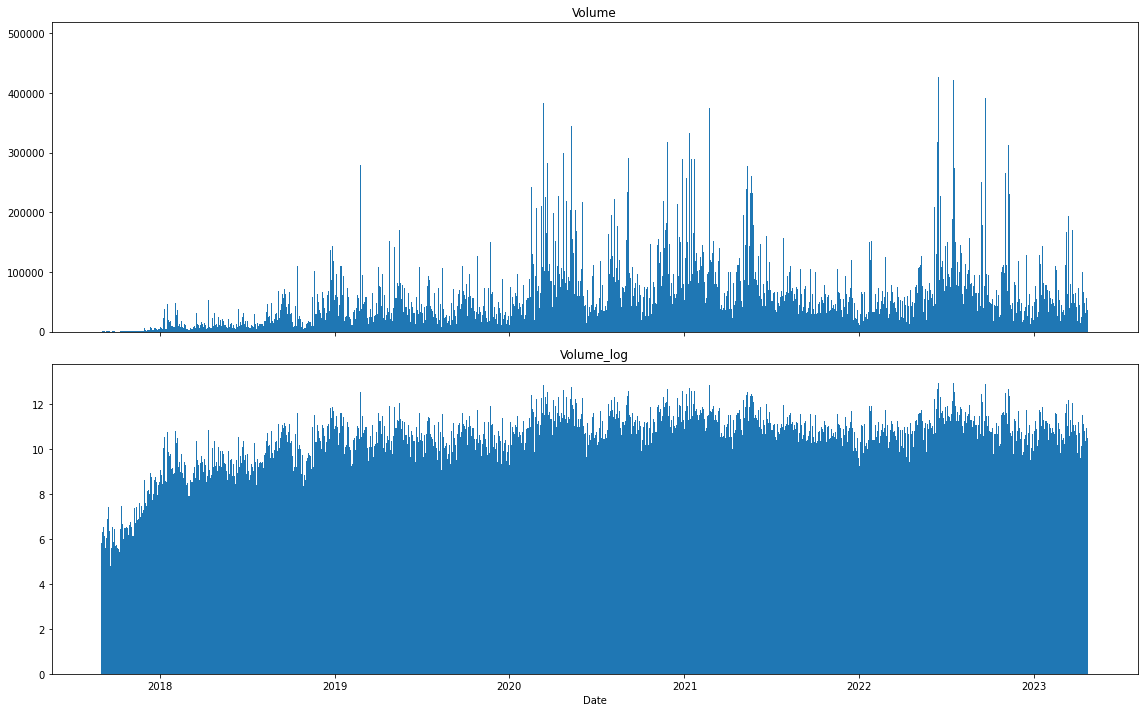

In [148]:
# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert index and columns to NumPy arrays
index_array = df.index.to_numpy()
vol_array = df['Volume'].to_numpy()
vol_log_array = df['Volume_log'].to_numpy()

ax[0].bar(index_array, vol_array)
ax[0].set_title('Volume')

ax[1].bar(index_array, vol_log_array)
ax[1].set_title('Volume_log')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

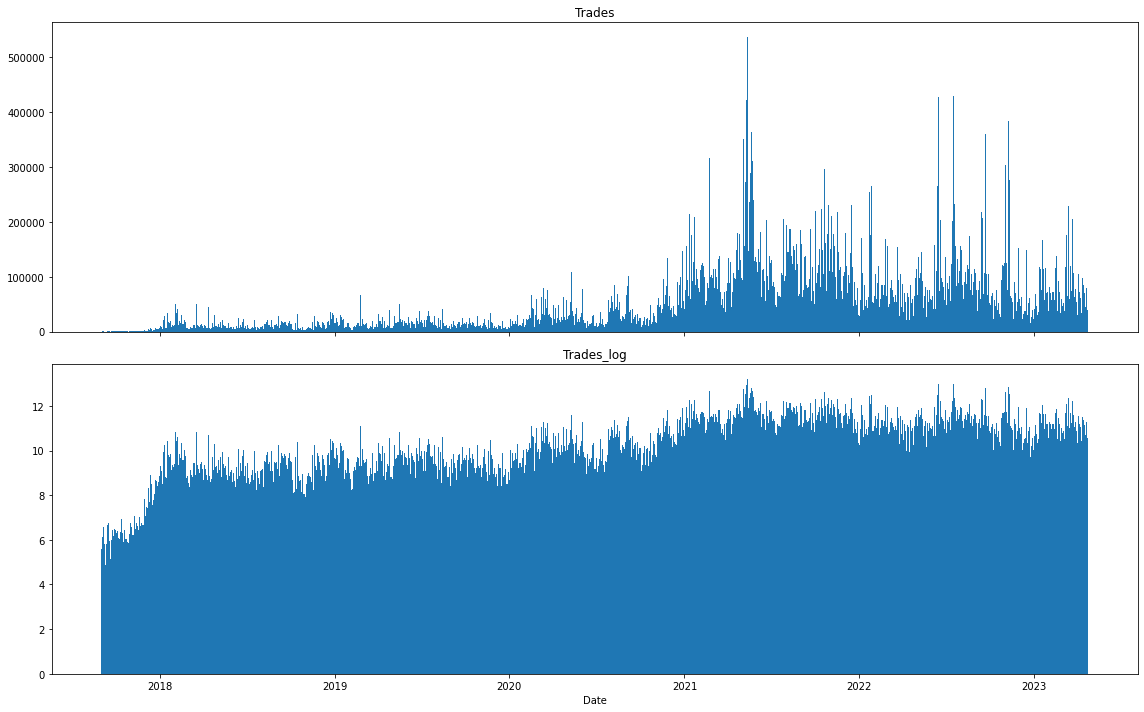

In [149]:
# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert index and columns to NumPy arrays
index_array = df.index.to_numpy()
vol_array = df['Trades'].to_numpy()
vol_log_array = df['Trades_log'].to_numpy()

ax[0].bar(index_array, vol_array)
ax[0].set_title('Trades')

ax[1].bar(index_array, vol_log_array)
ax[1].set_title('Trades_log')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Логарифмирование отлично трансформирует Volume, Trades

#### Обрабатываю High/Low, сравниваю исходную цену с логарифмированной

In [150]:
df['High_log'] = np.log(df['High'])
df['Low_log'] = np.log(df['Low'])

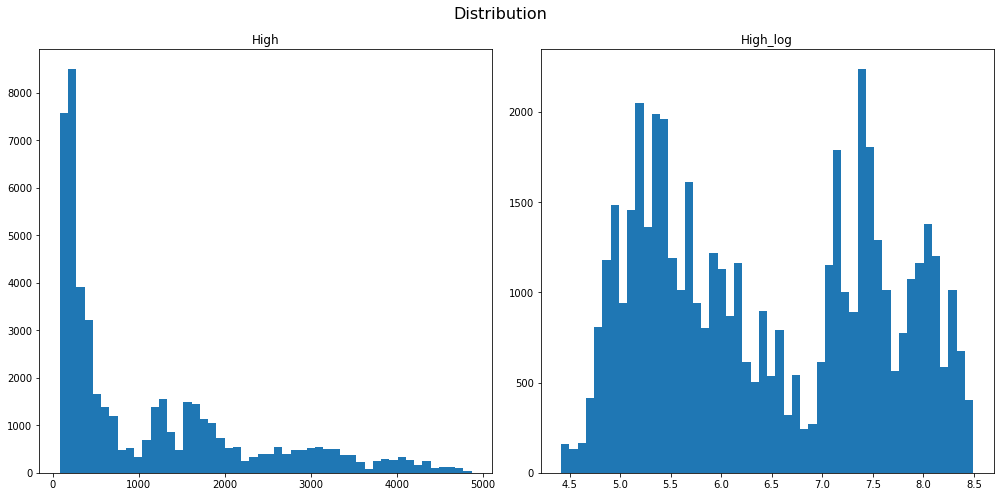

In [151]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Distribution', fontsize=16)

ax[0].hist(df['High'], 50)
ax[0].set_title('High')

ax[1].hist(df['High_log'], 50)
ax[1].set_title('High_log')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Опять же, распределение из лог-нормального становится хоть немного похожим на нормальное

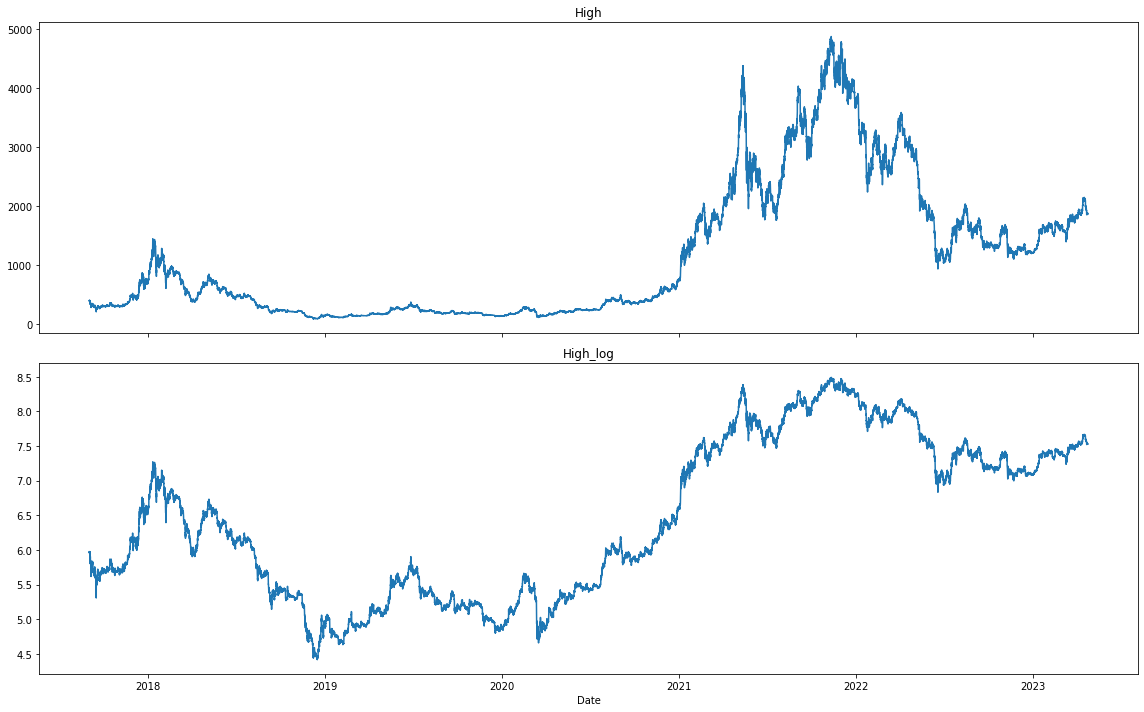

In [152]:
# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert index and columns to NumPy arrays
index_array = df.index.to_numpy()
close_array = df['High'].to_numpy()
close_log_array = df['High_log'].to_numpy()

ax[0].plot(index_array, close_array)
ax[0].set_title('High')

ax[1].plot(index_array, close_log_array)
ax[1].set_title('High_log')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

In [153]:
df['Open_log'] = np.log(df['Open'])

In [154]:
df['to_high_pct'] = (df['High'] / df['Open'] - 1)
df['to_high_log'] = df['High_log'] - df['Open_log']

In [155]:
df['to_low_pct'] = (df['Open'] / df['Low'] - 1)
df['to_low_log'] = df['Open_log'] - df['Low_log']

In [156]:
df[['Open', 'Open_log', 'High', 'High_log', 'to_high_pct', 'to_high_log', 'Low', 'Low_log', 'to_low_pct', 'to_low_log']]

,Open,Open_log,High,High_log,to_high_pct,to_high_log,Low,Low_log,to_low_pct,to_low_log
Datetime,,,,,,,,,,
2017-09-01 00:00:00,384.79,5.952698,388.74,5.962911,0.010265,0.010213,384.79,5.952698,0.000000,0.000000
2017-09-01 01:00:00,388.69,5.962782,394.06,5.976503,0.013816,0.013721,387.53,5.959793,0.002993,0.002989
2017-09-01 02:00:00,392.88,5.973504,394.39,5.977340,0.003843,0.003836,389.46,5.964761,0.008781,0.008743
2017-09-01 03:00:00,391.70,5.970496,393.13,5.974140,0.003651,0.003644,390.86,5.968349,0.002149,0.002147
2017-09-01 04:00:00,392.65,5.972919,394.27,5.977036,0.004126,0.004117,387.64,5.960077,0.012924,0.012842
...,...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,7.521188,1852.35,7.524210,0.003027,0.003022,1844.92,7.520191,0.000997,0.000997
2023-04-23 20:00:00,1846.49,7.521042,1852.30,7.524183,0.003147,0.003142,1838.03,7.516450,0.004603,0.004592
2023-04-23 21:00:00,1848.88,7.522335,1859.32,7.527966,0.005647,0.005631,1847.59,7.521637,0.000698,0.000698


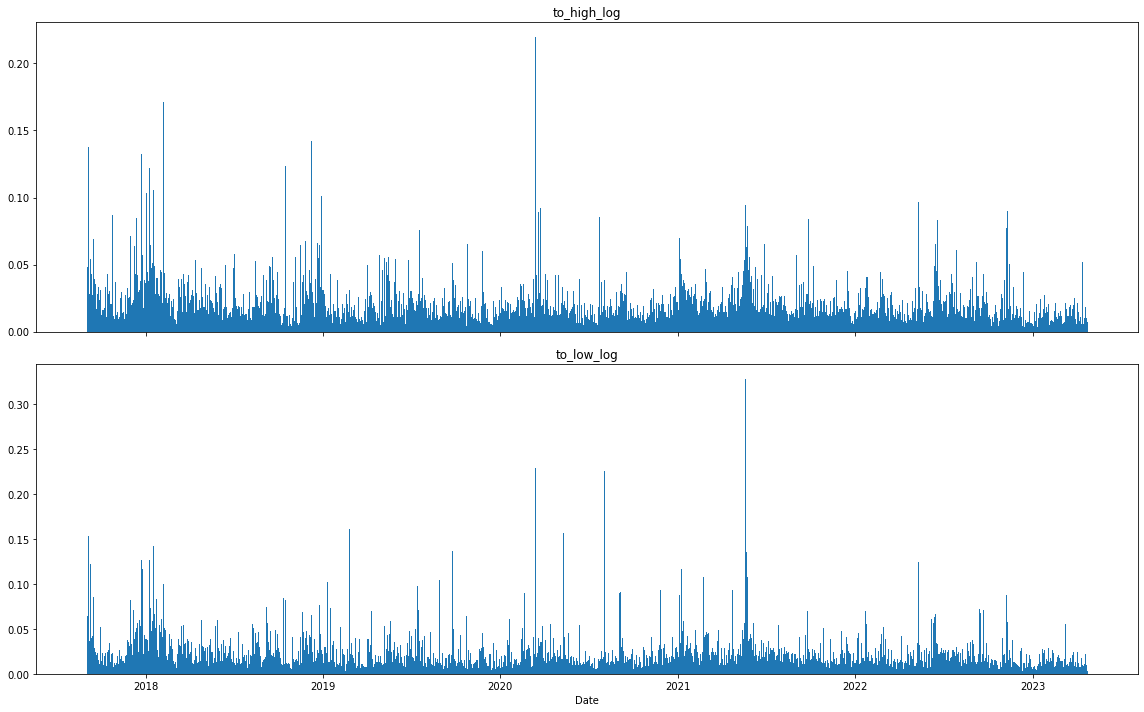

In [157]:
# Create a 2-row, 1-column subplot grid
fig, ax = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Convert index and columns to NumPy arrays
index_array = df.index.to_numpy()
vol_array = df['to_high_log'].to_numpy()
vol_log_array = df['to_low_log'].to_numpy()

ax[0].bar(index_array, vol_array)
ax[0].set_title('to_high_log')

ax[1].bar(index_array, vol_log_array)
ax[1].set_title('to_low_log')

# Set the x-axis label for the entire figure
plt.xlabel('Date')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

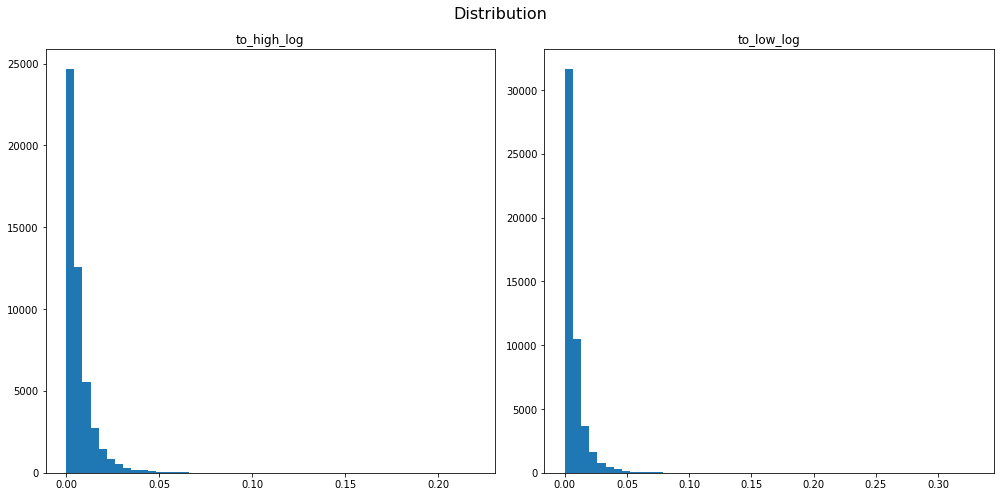

In [158]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Distribution', fontsize=16)

ax[0].hist(df['to_high_log'], 50)
ax[0].set_title('to_high_log')

ax[1].hist(df['to_low_log'], 50)
ax[1].set_title('to_low_log')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Лог-нормальные распределения, нужно логарифмировать что бы получилось подобие нормальных распределений.
Есть нулевые значение, т.е. отсутствие теней от открытия бара, поэтому нужно добавлять еденицы.

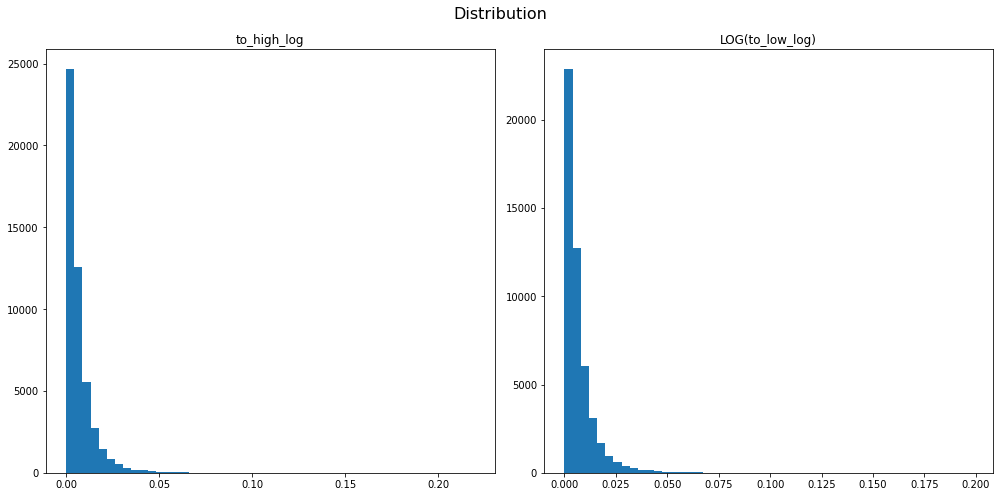

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Distribution', fontsize=16)

ax[0].hist(df['to_high_log'], 50)
ax[0].set_title('to_high_log')

ax[1].hist(np.log(df['to_high_log'] + 1), 50)
ax[1].set_title('LOG(to_low_log)')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Логарифмирование разницы ни к чему не привело.
Надо как-то подругому обрабатывать H/L.

Идея считать Return по макс и мин к предыдущему макс/мин. Как с ценой.

Пробую Return high log to previous high log

In [162]:
df['Return_High_log'] = df['High_log'] - df['High_log'].shift(1)
df['Return_Low_log'] = df['Low_log'] - df['Low_log'].shift(1)

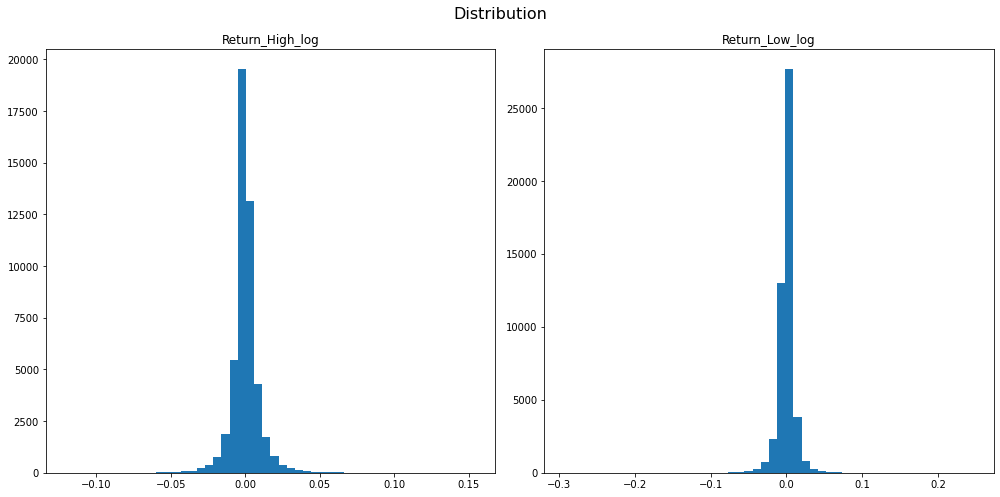

In [165]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Distribution', fontsize=16)

ax[0].hist(df['Return_High_log'], 50)
ax[0].set_title('Return_High_log')

ax[1].hist(df['Return_Low_log'], 50)
ax[1].set_title('Return_Low_log')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Разница логарифмических цен high/low выглядит хорошо, распределение нормальное.

Посмотрю как выглядит распределение разниц абсолютных цен High/Low.

In [166]:
df['Return_High'] = df['High'] - df['High'].shift(1)
df['Return_Low'] = df['Low'] - df['Low'].shift(1)

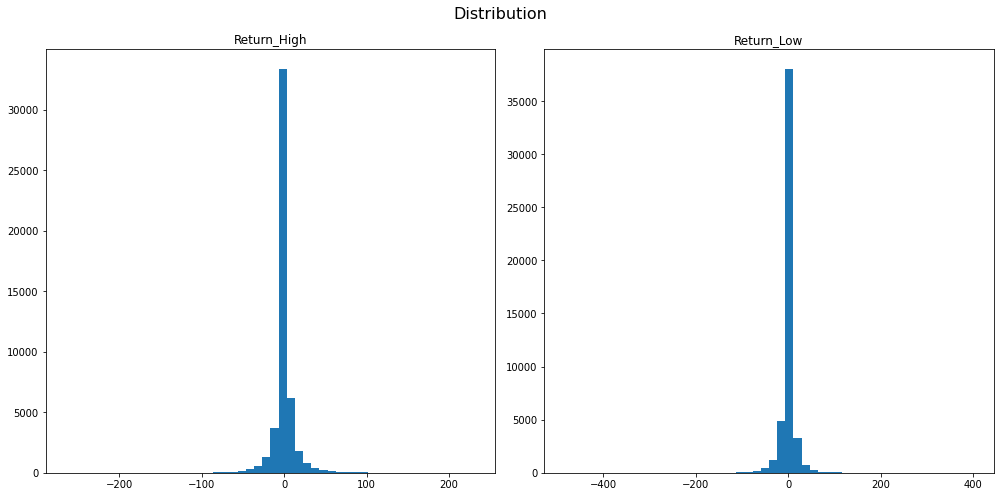

In [167]:
fig, ax = plt.subplots(1, 2, figsize=(14, 7))
fig.suptitle('Distribution', fontsize=16)

ax[0].hist(df['Return_High'], 50)
ax[0].set_title('Return_High')

ax[1].hist(df['Return_Low'], 50)
ax[1].set_title('Return_Low')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()

Нижняя и верхняя тень бара в процентах

In [168]:
low_shadow_pct = (np.where(df['Close'] > df['Open'], df['Open'], df['Close']) / df['Low'] - 1) * 100
high_shadow_pct = (df['High'] / np.where(df['Close'] <= df['Open'], df['Open'], df['Close']) - 1) * 100

In [169]:
df

,Open,High,Low,Close,Volume,Trades,Return,Return_log,Return_pct,Close_log,...,Low_log,Open_log,to_high_pct,to_high_log,to_low_pct,to_low_log,Return_High_log,Return_Low_log,Return_High,Return_Low
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-09-01 00:00:00,384.79,388.74,384.79,388.74,162.97779,131,3.95,0.010213,1.026534,5.962911,...,5.952698,5.952698,0.010265,0.010213,0.000000,0.000000,NaN,NaN,NaN,NaN
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262,2.68,0.006871,0.689495,5.969653,...,5.959793,5.962782,0.013816,0.013721,0.002993,0.002989,0.013592,0.007096,5.32,2.74
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225,-2.00,-0.005104,-0.509061,5.968401,...,5.964761,5.973504,0.003843,0.003836,0.008781,0.008743,0.000837,0.004968,0.33,1.93
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138,-0.84,-0.002147,-0.214450,5.968349,...,5.968349,5.970496,0.003651,0.003644,0.002149,0.002147,-0.003200,0.003588,-1.26,1.40
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128,-2.32,-0.005926,-0.590857,5.966993,...,5.960077,5.972919,0.004126,0.004117,0.012924,0.012842,0.002896,-0.008272,1.14,-3.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-23 19:00:00,1846.76,1852.35,1844.92,1846.49,16550.18290,21648,-0.27,-0.000146,-0.014620,7.521042,...,7.520191,7.521188,0.003027,0.003022,0.000997,0.000997,-0.004938,0.004645,-9.17,8.55
2023-04-23 20:00:00,1846.49,1852.30,1838.03,1848.89,13113.47550,19445,2.40,0.001299,0.129976,7.522341,...,7.516450,7.521042,0.003147,0.003142,0.004603,0.004592,-0.000027,-0.003742,-0.05,-6.89
2023-04-23 21:00:00,1848.88,1859.32,1847.59,1854.66,7855.61330,13824,5.78,0.003121,0.312622,7.525457,...,7.521637,7.522335,0.005647,0.005631,0.000698,0.000698,0.003783,0.005188,7.02,9.56


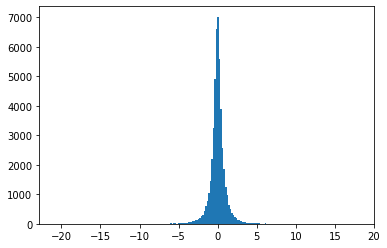

In [39]:
plt.hist(df['Return'], bins=200);

In [35]:
df['Return'].describe()

count    49337.000000
mean         0.008154
std          1.087834
min        -20.872775
25%         -0.386670
50%          0.007407
75%          0.413806
max         18.079244
Name: Return, dtype: float64

## Create Return as Category Target

Категориальный признак показывающий что текущий бар вырос 1 или упал 0

In [36]:
df['Return_cat_0'] = np.where(df['Return'] > 0, 1, 0)

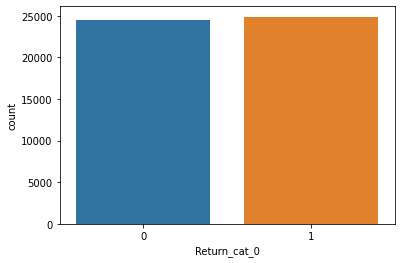

In [48]:
sns.countplot(data=df, x='Return_cat_0');

In [43]:
df['Return_cat_0'].value_counts(True) * 100

Return_cat_0
1    50.422604
0    49.577396
Name: proportion, dtype: float64

В таком виде классы достаточно сбалансированны, вопрос что будет после разделения

Категориальный признак показывающий что текущий бар вырос на 1% и боольше или вырос меньше либо вообще упал

In [44]:
df['Return_cat_1'] = np.where(df['Return'] >= 1, 1, 0)

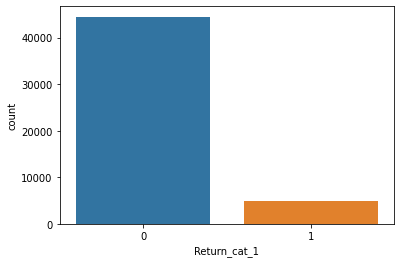

In [49]:
sns.countplot(data=df, x='Return_cat_1');

In [50]:
df['Return_cat_1'].value_counts(True) * 100

Return_cat_1
0    90.139246
1     9.860754
Name: proportion, dtype: float64

In [51]:
df['Return_cat_1'].value_counts()

Return_cat_1
0    44472
1     4865
Name: count, dtype: int64

Теперь получается что всего 10% от всей истории происходит рост на 1% и больше.
4865 часов

Категориальный признак показывающий, что текущий бар вырос на 1% и что нижняя тень не более 0.25%

In [52]:
df['Return_cat_1_ls'] = np.where((df['Return'] >= 1) & (low_shadow_pct <= 0.25), 1, 0)

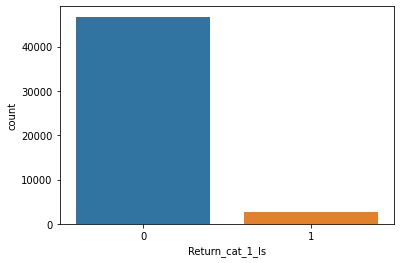

In [53]:
sns.countplot(data=df, x='Return_cat_1_ls');

In [55]:
df['Return_cat_1_ls'].value_counts(True) * 100

Return_cat_1_ls
0    94.748363
1     5.251637
Name: proportion, dtype: float64

In [56]:
df['Return_cat_1_ls'].value_counts()

Return_cat_1_ls
0    46746
1     2591
Name: count, dtype: int64

Таких ситуаций вообще всего 2591 часов или 5%

In [75]:
df.shape[0] // df['Return_cat_1_ls'].value_counts()[1]

19

В среднем каждые 19 часов появляется такой бар

Посмотрю на эти записи на последних днях истории

In [72]:
df[df['Return_cat_1_ls'] == 1].tail(50)

,Open,High,Low,Close,Volume,Trades,Return,Return_cat_0,Return_cat_1,Return_cat_1_ls
Datetime,,,,,,,,,,
2023-02-04 13:00:00,1666.06,1695.29,1666.06,1684.23,55647.4380,70793,1.090597,1,1,1
2023-02-07 19:00:00,1638.78,1657.89,1638.05,1656.35,25726.1633,45919,1.072139,1,1,1
2023-02-13 18:00:00,1472.61,1493.91,1471.85,1488.96,28848.2995,33039,1.110274,1,1,1
2023-02-15 11:00:00,1555.88,1580.00,1553.89,1572.26,38778.7872,45761,1.052780,1,1,1
2023-02-15 19:00:00,1591.40,1629.32,1588.42,1628.54,58281.3570,80150,2.333794,1,1,1
2023-02-16 15:00:00,1678.87,1728.69,1675.66,1724.14,86203.1172,121348,2.696457,1,1,1
2023-02-20 09:00:00,1691.96,1717.71,1688.50,1711.73,33666.4043,52054,1.168467,1,1,1
2023-02-23 02:00:00,1642.11,1675.06,1642.11,1671.99,44778.3077,67591,1.819610,1,1,1
2023-02-25 22:00:00,1574.58,1593.24,1571.68,1591.71,13457.7108,26620,1.087909,1,1,1


# Create dataset
## Define features and targets

In [14]:
features = data[['Open', 'High', 'Low', 'Close', 'Volume', 'Trades']].values
targets = data['Return_cat'].values

## Build Data
Define data dimension

In [15]:
T = 10 # len of sequence. Num of time steps to look at to make prediction on next step
D = features.shape[1] # Num of columns in input data. Features number.
N = features.shape[0] - T # Num of samples in dataset

In [16]:
X = np.zeros((N, T, D))
y = np.zeros(N)

for t in range(N):
  X[t, :, :] = features[t:t+T]
  y[t] = targets[t+T]

In [17]:
data.head(11)

,Open,High,Low,Close,Volume,Trades,Return,Return_cat
Datetime,,,,,,,,
2017-09-01 01:00:00,388.69,394.06,387.53,391.37,248.72949,262,0.676545,1
2017-09-01 02:00:00,392.88,394.39,389.46,390.88,198.82856,225,-0.125201,0
2017-09-01 03:00:00,391.70,393.13,390.86,390.86,141.56114,138,-0.005117,0
2017-09-01 04:00:00,392.65,394.27,387.64,390.33,135.65894,128,-0.135598,0
2017-09-01 05:00:00,388.92,388.99,384.88,384.88,203.48452,194,-1.396254,0
2017-09-01 06:00:00,386.70,388.62,383.18,384.52,85.07529,63,-0.093536,0
2017-09-01 07:00:00,386.26,390.56,384.00,388.40,330.22597,226,1.009050,1
2017-09-01 08:00:00,389.48,393.08,388.16,389.68,270.82415,209,0.329557,1
2017-09-01 09:00:00,389.97,392.00,387.46,389.14,248.32828,248,-0.138575,0


## Split Data

In [18]:
train_size = 0.66

# Создаем тренировочную и тестовую выборки с помощью train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, # таблица с наблюдениями и столбец с правильным ответами
    train_size=train_size, # размер тестовой выборки
    shuffle=True # пока не перемешиваю выборку попро
)

# Выводим размеры полученных выборок
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (32555, 10, 6)
Test shape: (16771, 10, 6)


## Normalization Data

In [19]:
# Create the scaler
scaler = preprocessing.StandardScaler()
# scaler = preprocessing.MinMaxScaler()

# Assuming X_train and X_test have shape (samples, len of sequence, num of features)
num_samples_train = X_train.shape[0]
num_samples_test = X_test.shape[0]

# Flatten the width and height dimensions
X_train_flattened = X_train.reshape(num_samples_train, -1)
X_test_flattened = X_test.reshape(num_samples_test, -1)

# Fit it to the training data
scaler.fit(X_train_flattened)

# Scale the flattened data
X_train_scaled = scaler.transform(X_train_flattened)
X_test_scaled = scaler.transform(X_test_flattened)

# Reshape the scaled data back to the original shape
X_train_scaled = X_train_scaled.reshape(X_train.shape)
X_test_scaled = X_test_scaled.reshape(X_test.shape)

# LSTM model Binary Classification

Вопрос - а как определять количество юнитов в слоях и глубину нейронки, количество слоев.

In [20]:
i = Input(shape=(T, D))
x = LSTM(100)(i)
x = Dense(1, activation='sigmoid')(x)  # можно использовать softmax, тогда на указать в выходном слое К=2 вместо 1

model = Model(i, x)
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.001),
    metrics=['accuracy']
)

## Train model

In [21]:
r = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    batch_size=32,
    epochs=50)

Epoch 1/50
1018/1018 [==============================] - 8s 6ms/step - loss: 0.6950 - accuracy: 0.4924 - val_loss: 0.6932 - val_accuracy: 0.4988
Epoch 2/50
1018/1018 [==============================] - 6s 5ms/step - loss: 0.6937 - accuracy: 0.4986 - val_loss: 0.6935 - val_accuracy: 0.4972
Epoch 3/50
1018/1018 [==============================] - 5s 5ms/step - loss: 0.6935 - accuracy: 0.5028 - val_loss: 0.6931 - val_accuracy: 0.5067
Epoch 4/50
1018/1018 [==============================] - 5s 5ms/step - loss: 0.6936 - accuracy: 0.4953 - val_loss: 0.6932 - val_accuracy: 0.5044
Epoch 5/50
1018/1018 [==============================] - 6s 6ms/step - loss: 0.6934 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5058
Epoch 6/50
1018/1018 [==============================] - 6s 6ms/step - loss: 0.6934 - accuracy: 0.4991 - val_loss: 0.6932 - val_accuracy: 0.4963
Epoch 7/50
1018/1018 [==============================] - 7s 7ms/step - loss: 0.6932 - accuracy: 0.5028 - val_loss: 0.6934 - val_accuracy:

## Learning Curve

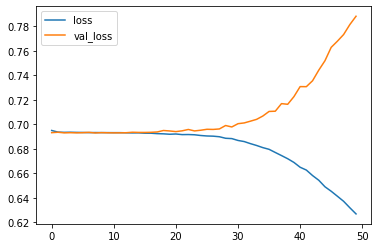

In [24]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

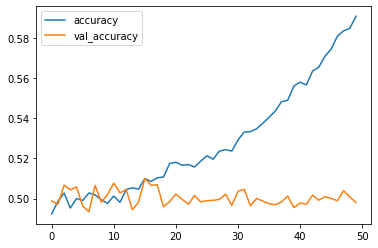

In [25]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend();

Модель вообще не показывает улучшения на валидационной выборке.
Accuracy на валидационной выборке болтается около 50%, но при этом уверенно растет на тренировочной выборке.
Значит модель подстроилась под шум.